In [23]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
np.random.seed(12211)  

import zeropoints

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)

In [2]:
num_train = 200000
num_test = 20000
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6]#6
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7]
surveystring = surveystring = ['SDSS', 'VIPERS', 'DEEP2', 'PRIMUS']

n_epochs = 2000 #20
D = 5 
K = 3
learning_rate = 1e-5
decay_rate= 1e-3 
batch_size = 1024 
save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [3]:
def load_trained_models(save_mod):
    ## load rescaling routines for colors/magnitude
    preproc = Pipeline([('stdscaler', StandardScaler())])
    scalerfile = save_mod + '_scaling_X'
    preproc = pickle.load(open(scalerfile, 'rb'))
    
    ## load rescaling routine for redshift
    preproc_y = Pipeline([('stdscaler', MinMaxScaler())])
    scalerfile = save_mod + '_scaling_y'
    preproc_y = pickle.load(open(scalerfile, 'rb'))

    ## Mixed density network
    non_lin_act = tf.nn.relu #tf.nn.tanh
    y_true = tf.keras.Input(shape=(1,))
    inputs = tf.keras.Input(shape=(D,))
    layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
    layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
    layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
    layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
    layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
    layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
    layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
    layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
    layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
    mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
    var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
    pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)
    model_train = Model([inputs, y_true], [mu, var, pi], name='mdn')
    
    # load network weights
    model_train.load_weights(save_mod + '.h5')
    
    return preproc, preproc_y, model_train

In [4]:
def minmax_cutsOBSarr(X, y, l):
    mask_cond =  np.where( 
        (X[:, 0] < max_col[0]) & (X[:, 0] > min_col[0]) &
        (X[:, 1] < max_col[1]) & (X[:, 1] > min_col[1]) &
        (X[:, 2] < max_col[2]) & (X[:, 2] > min_col[2]) &
        (X[:, 3] < max_col[3]) & (X[:, 3] > min_col[3]) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    X_new = X[mask_cond]
    y_new = y[mask_cond]
    l_new = l[mask_cond]
    return X_new, y_new, l_new, mask_cond

In [5]:
def print_limits(X, y):
    print(10*'-')
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))
    print(10*'-')

In [6]:
def loadTest(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_feb_2021/'):
    
    test_data = np.load(dirIn + 'test_' + Testset + '.npy') 

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    print_limits(X_test, y_test)

    X_err = np.load(dirIn + 'test_' + Testset +'_err.npy') 
    test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return X_test, y_test, X_err, test_labels

In [11]:
## Loading color, redshift information from different surveys
X_test, y_test, X_err, label_test = loadTest(dirIn = 'Data/fromGalaxev/photozs/datasets/data_feb_2021/')

----------
number of datapoints:  4339
z-minmax:  7.926745e-06 7.01
ColMag-min:  [ -5.188479   -3.8901405  -2.1034117 -15.92296    12.114799 ]
ColMag-max:  [17.02884   7.925968  4.182415  2.264679 25.709858]
----------


In [12]:
## Removing galaxies outside the range of prediction scheme. 
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.001 #np.min(y_train) 
max_z = 1.1 #np.max(y_train) 

X_test, y_test, label_test, mask_cond = minmax_cutsOBSarr(X_test, y_test, label_test)
X_err = X_err[mask_cond]
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in test data: (2741, 5)
Size of output in test data: (2741,)


In [13]:
## Loading trained models and rescaling routines
preproc, preproc_y, model_train = load_trained_models(save_mod)

In [20]:
# Should cover at least the extent of the true redshifts.
zgrid = np.arange(-0.1,0.8,0.01)

# Selection. SDSS galaxies above z>0.01.
sel = (label_test==0)&(y_test>0.01)

# Value to reduce the likelihood ratio significance. 
# Adjust higher for larger samples.
extra_cov = (7.)**2
# Integration steps to marginalize photometric noise.
Nintegral = 10
# Clip galaxies with crazy low likelihoods. Roughly number of sigmas.
cutoff = 5
# Steps of the MCMC.
Nchain = 100

errors = X_err[sel].copy()
# Sometimes it's good to add more error. 
# Our models will not be accurate up to S/N~1000
# errors = np.sqrt(errors**2 + 0.02**2)

# Step size of the proposal distribution.
step_size = 0.005

xchain, P = zeropoints.run_zp_chain(
    preproc,
    preproc_y,
    model_train,
    y_test[sel], 
    X_test[sel].copy(), 
    errors, 
    Nintegral,
    Nchain,
    method = "exact", # Exact likelihood
    #method = "approximate", # Approximate likelihood.
    params_init = None,
    #params_init = pinit,
    cutoff = cutoff, 
    extra_cov = extra_cov,
    step_size = step_size,
    zgrid = zgrid
)

/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.692826747894287
0 [0. 0. 0. 0.] 7517.31


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.856282234191895
0 [ 0.0026  0.0006  0.0018 -0.0049] 7479.52


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.696351051330566
1 [ 0.0022  0.0006 -0.0062 -0.004 ] 7484.01


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.956177949905396
2 [ 0.0022  0.0006 -0.0062 -0.004 ] 7484.01


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.706450939178467
3 [ 0.0016  0.0045 -0.0119 -0.002 ] 7384.56


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


17.07612705230713
4 [ 0.0109  0.0061 -0.0141 -0.0077] 7358.07


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.859416007995605
5 [ 0.0056  0.0114 -0.0103 -0.0047] 7297.2


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.446635723114014
6 [ 0.0056  0.0114 -0.0103 -0.0047] 7297.2


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.131829977035522
7 [ 0.0056  0.0114 -0.0103 -0.0047] 7297.2


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.554029941558838
8 [-0.0028  0.0167 -0.0141 -0.0092] 7213.78


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


19.85042905807495
9 [ 0.0022  0.0136 -0.0098 -0.0049] 7215.47


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


19.5235378742218
10 [ 0.0022  0.0136 -0.0098 -0.0049] 7215.47


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


17.317649126052856
11 [ 0.0022  0.0136 -0.0098 -0.0049] 7215.47


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.166305780410767
12 [ 0.0022  0.0136 -0.0098 -0.0049] 7215.47


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.668168306350708
13 [ 0.0022  0.0136 -0.0098 -0.0049] 7215.47


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.528201818466187
14 [ 0.0022  0.0136 -0.0098 -0.0049] 7215.47


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.72166395187378
15 [ 0.0022  0.0136 -0.0098 -0.0049] 7215.47


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.720555067062378
16 [ 0.0022  0.0136 -0.0098 -0.0049] 7215.47


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.41715908050537
17 [ 0.0022  0.0136 -0.0098 -0.0049] 7215.47


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.884249210357666
18 [-0.0004  0.0136 -0.0057 -0.0055] 7355.0


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.820343017578125
19 [ 0.0015  0.0119 -0.0145 -0.0024] 7371.74


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.990287780761719
20 [ 0.0015  0.0119 -0.0145 -0.0024] 7371.74


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.484730958938599
21 [ 0.0046  0.0116 -0.0107 -0.0052] 7245.48


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.376183032989502
22 [ 0.0123  0.0099 -0.0081 -0.0082] 7412.77


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.564976215362549
23 [ 0.003   0.0163 -0.0096 -0.013 ] 7244.49


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.817224025726318
24 [ 0.0058  0.0219 -0.0125 -0.0097] 7162.51


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.256947994232178
25 [ 0.0058  0.0219 -0.0125 -0.0097] 7162.51


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.554498672485352
26 [ 0.0058  0.0219 -0.0125 -0.0097] 7162.51


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.870877027511597
27 [ 0.0058  0.0219 -0.0125 -0.0097] 7162.51


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.689372777938843
28 [ 0.0099  0.0252 -0.0134 -0.0194] 7121.45


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.528330087661743
29 [-0.0009  0.0192 -0.0119 -0.0175] 7282.04


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.504849910736084
30 [ 0.0014  0.0137 -0.0087 -0.0187] 7252.45


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.574794292449951
31 [ 0.0014  0.0137 -0.0087 -0.0187] 7252.45


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.543363809585571
32 [-0.0011  0.0131 -0.0103 -0.0176] 7300.45


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.378330945968628
33 [-0.0088  0.0069 -0.0152 -0.0207] 7278.14


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.491913795471191
34 [-0.0061  0.009  -0.0188 -0.0271] 7225.7


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.645975589752197
35 [-0.0061  0.009  -0.0188 -0.0271] 7225.7


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.09513807296753
36 [-0.0056  0.0047 -0.0255 -0.0289] 7185.67


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.006576776504517
37 [-0.0056  0.0047 -0.0255 -0.0289] 7185.67


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.631989002227783
38 [-0.0144  0.0078 -0.0255 -0.0303] 7086.89


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.789993047714233
39 [-0.0144  0.0078 -0.0255 -0.0303] 7086.89


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.626368045806885
40 [-0.0114  0.013  -0.0241 -0.0315] 7095.91


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.789469957351685
41 [-0.0114  0.013  -0.0241 -0.0315] 7095.91


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.968093156814575
42 [-0.0114  0.013  -0.0241 -0.0315] 7095.91


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.356934785842896
43 [-0.0109  0.0092 -0.0152 -0.0332] 7158.79


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.71913480758667
44 [-0.0109  0.0092 -0.0152 -0.0332] 7158.79


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.213653802871704
45 [ 0.0036  0.0033 -0.0059 -0.0336] 7306.82


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.826212167739868
46 [ 0.0036  0.0033 -0.0059 -0.0336] 7306.82


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.88365387916565
47 [-0.0072  0.0037 -0.004  -0.0304] 7282.42


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.292134761810303
48 [-0.0124  0.0081 -0.0043 -0.0261] 7288.45


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.432482957839966
49 [-0.0042  0.0065  0.0005 -0.0255] 7288.27


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.798607110977173
50 [-0.0084  0.0063  0.0022 -0.0257] 7227.16


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.415933847427368
51 [-0.0063  0.0111  0.0021 -0.03  ] 7194.96


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.819055318832397
52 [-0.0063  0.0111  0.0021 -0.03  ] 7194.96


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


17.55790901184082
53 [-0.0063  0.0111  0.0021 -0.03  ] 7194.96


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.108880996704102
54 [-0.0106  0.0155  0.0037 -0.0246] 7298.16


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.267881870269775
55 [-0.0018  0.0184  0.0026 -0.0246] 7271.91


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.87263298034668
56 [-0.0013  0.0142  0.0004 -0.024 ] 7342.12


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


17.668934106826782
57 [ 0.0077  0.0151  0.0032 -0.0242] 7264.89


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.22306799888611
58 [ 0.0056  0.0112 -0.0096 -0.0252] 7217.83


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


17.14370584487915
59 [ 0.002   0.017  -0.0038 -0.0222] 7252.94


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.920090198516846
60 [ 0.0056  0.0223 -0.0038 -0.0117] 7192.15


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


17.709925889968872
61 [ 0.0056  0.0223 -0.0038 -0.0117] 7192.15


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.507106065750122
62 [-0.0013  0.0278 -0.0002 -0.0154] 7099.62


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.49828314781189
63 [-0.0013  0.0278 -0.0002 -0.0154] 7099.62


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.1412410736084
64 [-0.0013  0.0278 -0.0002 -0.0154] 7099.62


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.622765064239502
65 [-0.0013  0.0278 -0.0002 -0.0154] 7099.62


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.536869764328003
66 [-0.0013  0.0278 -0.0002 -0.0154] 7099.62


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.517467260360718
67 [-0.003   0.028  -0.0068 -0.0189] 7240.32


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.606430053710938
68 [-0.005   0.0283 -0.0099 -0.0226] 7176.97


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.42654800415039
69 [-0.0015  0.0414 -0.0117 -0.018 ] 7004.34


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.044574975967407
70 [-0.0015  0.0414 -0.0117 -0.018 ] 7004.34


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.09416103363037
71 [-0.0015  0.0414 -0.0117 -0.018 ] 7004.34


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: invalid value encountered in add
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


17.88520312309265
72 [-0.0015  0.0414 -0.0117 -0.018 ] 7004.34


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


18.093345165252686
73 [-0.0015  0.0414 -0.0117 -0.018 ] 7004.34


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.010496854782104
74 [-0.0015  0.0414 -0.0117 -0.018 ] 7004.34


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.688652992248535
75 [-0.0015  0.0414 -0.0117 -0.018 ] 7004.34


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.771652936935425
76 [-0.0044  0.0434 -0.0191 -0.0023] 7139.62


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.268642902374268
77 [ 0.0045  0.0452 -0.0198 -0.0017] 7115.26


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.457390069961548
78 [ 0.009   0.0439 -0.0132  0.011 ] 7138.05


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.933820962905884
79 [ 0.005   0.049  -0.0066  0.0117] 7273.29


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.660768032073975
80 [ 0.0074  0.0544 -0.0133  0.0193] 7107.72


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


17.570191860198975
81 [ 0.0056  0.0547 -0.0167  0.0157] 7224.44


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


17.096491813659668
82 [ 0.0062  0.0583 -0.0237  0.0166] 7110.86


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.496177911758423
83 [ 0.005   0.0661 -0.0201  0.0156] 7016.37


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.174760103225708
84 [ 0.005   0.0661 -0.0201  0.0156] 7016.37


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.820861101150513
85 [ 0.0052  0.0701 -0.0164  0.0058] 7169.4


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.586665868759155
86 [ 0.0072  0.0738 -0.0151  0.0054] 7111.6


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.647621870040894
87 [ 0.0067  0.0692 -0.0237  0.0056] 7064.56


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.713374853134155
88 [ 0.0067  0.0692 -0.0237  0.0056] 7064.56


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.182761192321777
89 [-0.0002  0.0685 -0.0245  0.0007] 7047.53


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.023976802825928
90 [ 0.0022  0.0672 -0.0226  0.0035] 6971.33


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.761340141296387
91 [ 0.0022  0.0672 -0.0226  0.0035] 6971.33


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.696330070495605
92 [ 0.0022  0.0672 -0.0226  0.0035] 6971.33


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


15.161281108856201
93 [ 0.0022  0.0672 -0.0226  0.0035] 6971.33


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.739516019821167
94 [ 0.0022  0.0672 -0.0226  0.0035] 6971.33


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.052738189697266
95 [ 0.0022  0.0672 -0.0226  0.0035] 6971.33


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


16.6982319355011
96 [ 0.0022  0.0672 -0.0226  0.0035] 6971.33


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


14.795478820800781
97 [ 0.0022  0.0672 -0.0226  0.0035] 6971.33
15.311384916305542
98 [ 0.0022  0.0672 -0.0226  0.0035] 6971.33


/Users/alarcon/Documents/source/MDN_phoZ/zeropoints.py:99: RuntimeWarning: divide by zero encountered in log
  loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)


In [21]:
def prediction_zp(xdata, xzero):
 
    f_real = xdata.copy()
    f_real[:,:4] = f_real[:,:4] + xzero
    f_real = preproc.transform(f_real)
    y_pred = np.array(model_train(f_real))


    y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
    y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]

    photoz = preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0]
    return photoz

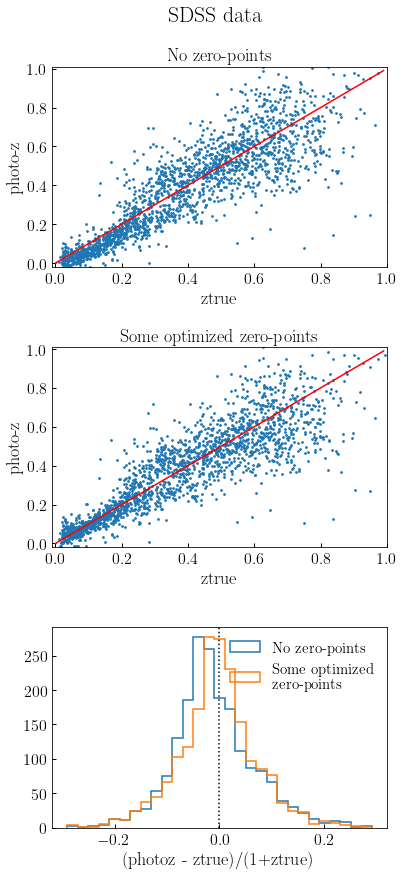

In [24]:
xdata = X_test[sel].copy()

zb_0 = prediction_zp(xdata, 0.*xchain[P.argmin()])
zb_zp = prediction_zp(xdata, xchain[P.argmin()])


fig,ax = plt.subplots(3,1, figsize=(6,14), sharex=False, sharey=False)
ax[0].scatter(y_test[sel], zb_0, s=3)
ax[0].plot([0,0.99],[0,0.99], color='r')
ax[0].set_xlim(-0.01,0.99+0.01)
ax[0].set_ylim(-0.02,0.99+0.02)
ax[0].set_xlabel('ztrue')
ax[0].set_ylabel('photo-z')
ax[0].set_title('No zero-points')

ax[1].scatter(y_test[sel], zb_zp, s=3)
ax[1].plot([0,0.99],[0,0.99], color='r')
ax[1].set_xlim(-0.01,0.99+0.01)
ax[1].set_ylim(-0.02,0.99+0.02)
ax[1].set_xlabel('ztrue')
ax[1].set_ylabel('photo-z')
ax[1].set_title('Some optimized zero-points')

dz_bins = 0.02
bins = np.arange(-0.3+dz_bins/2., 0.3, dz_bins)
ax[2].hist((zb_0-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='No zero-points')
ax[2].hist((zb_zp-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='Some optimized \nzero-points')
ax[2].axvline(0,ls=':',color='k')
ax[2].set_xlabel('(photoz - ztrue)/(1+ztrue)')
ax[2].legend()

fig.suptitle('SDSS data', y=0.94)
fig.subplots_adjust(hspace=0.4)
#plt.savefig('zeropoint_sdss_test1.png',bbox_inches='tight',dpi=300)
plt.show()

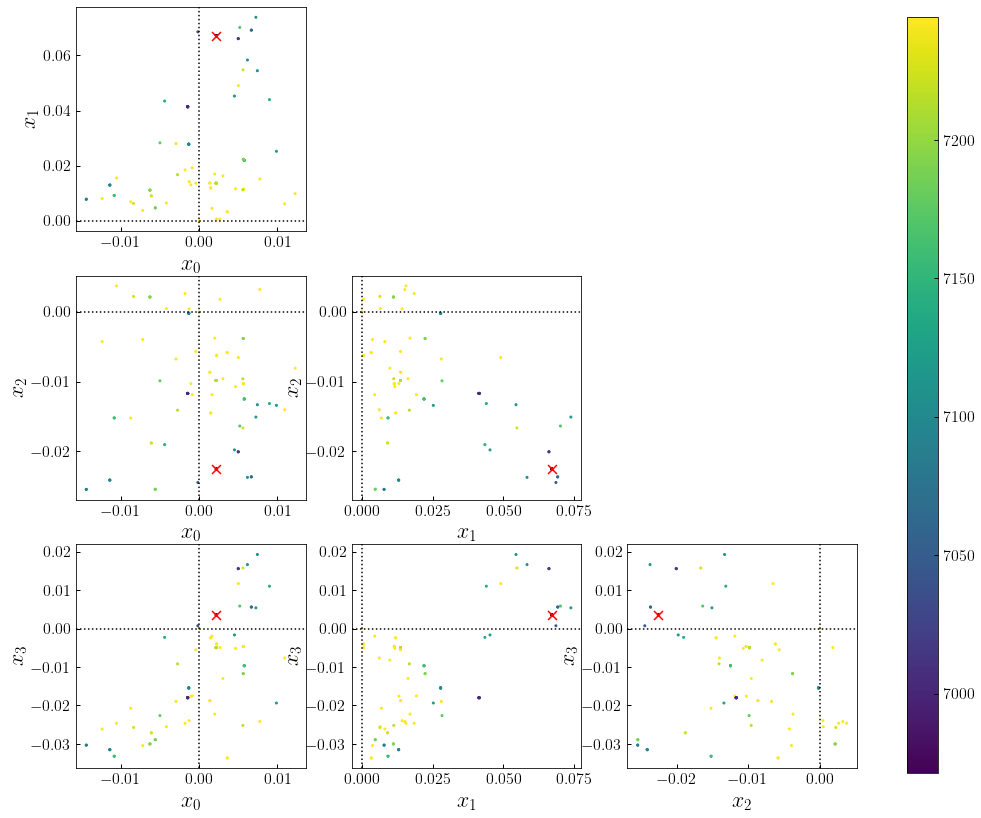

In [26]:
fig, ax = plt.subplots(3,3, figsize=(14,14))

for i in range(3):
    for j in range(3):
        if i<j:
            ax[i,j].axis('off')
            continue
            
        im = ax[i,j].scatter(xchain[:,j],xchain[:,i+1], s=4,c=P, vmin=P.min(), vmax=np.mean([P.min(),P.max()]))
        argmin = P.argmin()
        ax[i,j].scatter(xchain[argmin,j],xchain[argmin,i+1], s=80, c='r', marker='x')
        ax[i,j].set_xlabel(f'$x_{j}$', fontsize=22)
        ax[i,j].set_ylabel(f'$x_{i+1}$', fontsize=22)
        ax[i,j].axvline(0, ls=':', color='k')
        ax[i,j].axhline(0, ls=':', color='k')
        
        #assert false
        
#fig.colorbar(im,ax=ax[i,j])
cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.75])
fig.colorbar(im, cax=cbar_ax)
#fig.tight_layout()
plt.show()